In [1]:
!pip install xgboost

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from collections import Counter

In [2]:
df_standard = pd.read_csv('df.eneemr')

https://xgboost.readthedocs.io/en/latest/index.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

KLASSENIMBALANZ BERÜCKSICHTIGT

In [4]:
leakage_features = [
    "summonerLevel",
    "winrate",
    "smurf_score",
    "smurf_ratio"
]

df_model = df_standard.copy()

X = (
    df_model
    .select_dtypes(include=["float64", "int64"])
    .drop(columns=["smurf_flag"] + leakage_features, errors="ignore")
)

y = df_model["smurf_flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [5]:
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

print("Class distribution:", counter)
print("scale_pos_weight:", scale_pos_weight)

Class distribution: Counter({0: 22025, 1: 570})
scale_pos_weight: 38.64035087719298


In [7]:
# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.45, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# Random Forest (balanced)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)
y_prob_rf = rf.predict_proba(X_test_pca)[:, 1]

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("PR-AUC:", average_precision_score(y_test, y_prob_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# XGBoost (balanced)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train_pca, y_train)
y_pred_xgb = xgb.predict(X_test_pca)
y_prob_xgb = xgb.predict_proba(X_test_pca)[:, 1]

print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("PR-AUC:", average_precision_score(y_test, y_prob_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5507
           1       1.00      0.80      0.89       142

    accuracy                           1.00      5649
   macro avg       1.00      0.90      0.94      5649
weighted avg       1.00      1.00      0.99      5649

ROC-AUC: 0.9550827755711682
PR-AUC: 0.8547445481180845
Confusion Matrix:
 [[5507    0]
 [  28  114]]

XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5507
           1       0.69      0.82      0.75       142

    accuracy                           0.99      5649
   macro avg       0.84      0.90      0.87      5649
weighted avg       0.99      0.99      0.99      5649

ROC-AUC: 0.921610651744131
PR-AUC: 0.8294677781069123
Confusion Matrix:
 [[5455   52]
 [  26  116]]


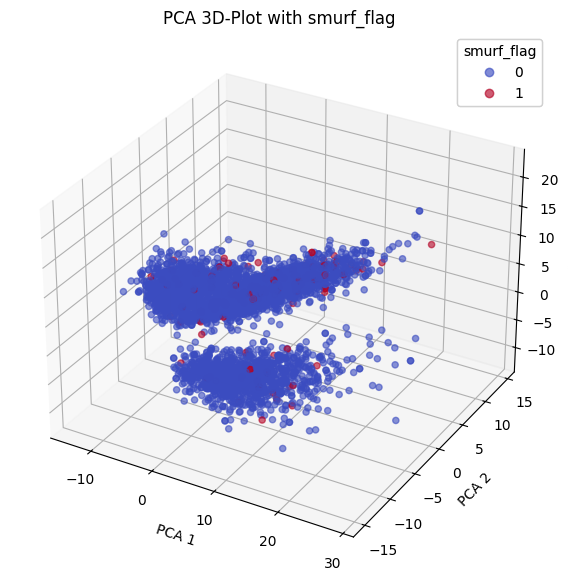

In [9]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=y_test, cmap='coolwarm', alpha=0.6)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('PCA 3D-Plot with smurf_flag')
legend1 = ax.legend(*scatter.legend_elements(), title="smurf_flag")
ax.add_artist(legend1)
plt.show()